# Churn Analysis for Sparkify
# Content
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
    <ul><li><a href="#gather">Gather data</a></li></ul>
    <ul><li><a href="#assess_and_clean">Assess and clean</a></li></ul>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

<a id='intro'></a>
# Intro
We're analyzing data of a music streaming service named Sparkify. The goal is the prediction of customer turnover (churn). The full dataset is 12 GB of logfile data. Apache Spark as a technology for distributed data processing is used to cope with this amount of data. This workspace uses a 0.1 GB subset of the data.

<a id='wrangling'></a>
# Data Wrangling
<a id='gather'></a>
## Gather data
Import libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
%matplotlib inline

import datetime
import time

from pyspark.sql import SparkSession, Window
import pyspark.sql.functions as F
from pyspark.sql.functions import count, when, isnan, col, desc, udf, avg, row_number, datediff, lit
from pyspark.sql.types import IntegerType
from pyspark.ml import Pipeline, PipelineModel
from pyspark.ml.feature import VectorAssembler, StringIndexer, StandardScaler
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator

Create a Spark session

In [2]:
spark = SparkSession.builder \
    .appName('Sparkify') \
    .getOrCreate()

In [3]:
sparkify = 'mini_sparkify_event_data.json'
# path = "s3n://udacity-dsnd/sparkify/mini_sparkify_event_data.json"
df = spark.read.json(sparkify)
df.persist()

DataFrame[artist: string, auth: string, firstName: string, gender: string, itemInSession: bigint, lastName: string, length: double, level: string, location: string, method: string, page: string, registration: bigint, sessionId: bigint, song: string, status: bigint, ts: bigint, userAgent: string, userId: string]

<a id='assess_and_clean'></a>
## Assess and clean

In [4]:
print('The dataset has {} rows and {} users.'.format(df.count(), df.select('userId').drop_duplicates().count()))

The dataset has 286500 rows and 226 users.


In [ ]:
df.printSchema()

In [ ]:
df.head(1)

In [ ]:
# lines per user
df.groupby('userId').count().orderBy(desc('count')).show(5)

Summary statistics: learn about the data and find unexpected entries:

In [ ]:
df.describe(df.columns[:6]).show()

In [ ]:
df.describe(df.columns[7:13]).show()

In [ ]:
df.describe(df.columns[14:]).show()

### Invalid/missing data
#### userID and sessionID: We find no NaN or Null values  ...

In [5]:
# inspired by https://stackoverflow.com/questions/44627386/how-to-find-count-of-null-and-nan-values-for-each-column-in-a-pyspark-dataframe/44631639#44631639
df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]).collect()

[Row(artist=58392, auth=0, firstName=8346, gender=8346, itemInSession=0, lastName=8346, length=58392, level=0, location=8346, method=0, page=0, registration=8346, sessionId=0, song=58392, status=0, ts=0, userAgent=8346, userId=0)]

#### ... but some empty strings in userID
The function 'describe' above shows there is no empty string in `sessionId` but at least one empty string in `userId` (min() is empty string).

We notice that for empty `userId`s the auth shows 'Logged Out'...

In [ ]:
print('UserId is empty in {} cases.'.format(df.filter(df.userId == '').count()))
df.filter(df.userId == '').groupBy('auth').count()

... and we find that __the userId is missing _only_ when the user is not logged in__:

In [ ]:
df.filter((df.userId == '') & (df.auth != 'Logged In')).count()

#### Remove lines w/o userId
__Define:__<br>
filter using `userId != ''`.

__Code:__

In [6]:
lines_0 = df.count()
df = df.filter(df.userId != '')

__Test:__

In [ ]:
df.groupBy('auth').count().show()

In [ ]:
print('{:.0%} (count: {}) of the dataset rows are left.'.format(df.count() / lines_0, df.count()))

### NaN in other columns
NaN check above reveals: song, length, artist are missing the same number of rows & are missing more rows than the userId.

In [ ]:
print("{} lines are completely filled and there are {} lines where the 'page' is 'NextSong'.".format(
    df.dropna(how='any').count(),
    df.filter(~df.song.isNull()).groupBy('page').count().sort(desc('count')).select('count').collect()))

print('\n{:.0%} of the log entries are songs requested.'.format(df.dropna(how='any').count() / df.count()))

The columns song, length, artist are filled when the Sparkify user listens to songs. They are not filled e.g. for log entries "Add to Playlist", "Thumbs Up", etc.

$\rightarrow$ no problems to tackle with NaN values in other columns

<a id='eda'></a>
# Exploratory Data Analysis

Those with most rows when logged in are candidates for the most heavy users:

In [ ]:
df.groupBy('userId').count().sort(desc('count')).show(5)

## Define Churn
### Check how to identify churn

In [7]:
#df.select('page').dropDuplicates().sort('page').show() # identification step
cancel_event_count = df.where(df.page == 'Cancellation Confirmation').count()
account_count = df.select('userId').drop_duplicates().count()
print('There are {} cancellation events for {} accounts in the dataset (i.e. {:.0%} churn).'.format( 
    cancel_event_count, account_count, cancel_event_count / account_count))

There are 52 cancellation events for 225 accounts in the dataset (i.e. 23% churn).


$\rightarrow$ adequate churn share in data to train a model

### Create churn column
__Define:__<br> 
Identify Churn as `df.page == 'Cancellation Confirmation'`. Create a column `Churn_user` which is 1 for a user with a cancellation confirmation. The cancellation is possible for both paid and free users.

__Code:__

In [8]:
# create flag churn
churn_event = udf(lambda x: 1 if x == 'Cancellation Confirmation' else 0, IntegerType())

# create churn column: mark event
df = df.withColumn('Churn', churn_event(df.page))

# create churn column: mark customer (=userId); heavy lifting by Spark, list of userIds easier with Pandas
users_churn = df.where(df.Churn == 1).select('userId').drop_duplicates().toPandas().values.tolist()
users_churn = list(np.concatenate(users_churn).flat)  
df = df.withColumn('Churn_user', when(col('userId').isin(users_churn), 1).otherwise(0))
print('{} users churned'.format(df.select('userId').filter(df.userId.isin(users_churn)).dropDuplicates().count()))

52 users churned


#### Test:
column 'Churn' is 1 only in in cancellation row

In [ ]:
df.select(['userId', 'firstName', 'ts', 'page', 'level', 'Churn']).where(df.userId == '125').sort('ts').collect() #9

In [ ]:
df_churn_pd = df.select(['userId', 'Churn_user']).drop_duplicates().groupBy('Churn_user').count().toPandas()

plt.figure(figsize = (6, 3))
sb.set_style('darkgrid')
sb.barplot(y='count', x='Churn_user', data=df_churn_pd)
plt.title('User Count by Churn', fontsize=16)
plt.xlabel('Churn (1=yes)', fontsize=12)
plt.ylabel('Count', fontsize=12);

In [ ]:
#### possible extension: consider `Downgrade` events:
#= do not consider churn where a user cancels a paid subscription
#
### create flag downgrade
#flag_downgrade_event = udf(lambda x: 1 if x=='Submit Downgrade' else 0, IntegerType())
#
### create downgraded column
#df = df.withColumn('downgraded', flag_downgrade_event('page'))
#
### create flag free or paid phase
#windowval = Window.partitionBy('userId').orderBy(desc('ts')).rangeBetween(Window.unboundedPreceding, 0)
#df = df.withColumn('phase', F.sum('downgraded').over(windowval)) # phase: 1=paid before downgrade, 0=free 
#
##df.select(['userId', 'firstName', 'ts', 'page', 'level', 'phase']).where(df.userId == '30').sort('ts').collect() #9

## Songs per User

As one approach we divide into users who cancel the usage. This is possible for both paid and free users.

#### Songs per User ... first impression, and then the next step: consider time scaling (e.g. per day) 
Those who cancel the service did use it considerably on average.

In [9]:
songs_by_churn = df.filter(df.page == 'NextSong').groupby(df.Churn_user).count().orderBy(df.Churn_user).toPandas()['count']
count_by_churn = df.groupBy('Churn').count().orderBy('Churn').toPandas()['count']
print('Songs by churn:\n', songs_by_churn, 
      '\n\nSongs per User by Churn:\n', songs_by_churn / count_by_churn)

Songs by churn:
 0    191714
1     36394
Name: count, dtype: int64 

Songs per User by Churn:
 0      0.689366
1    699.884615
Name: count, dtype: float64


Most heavy users of those who cancel:

In [ ]:
df.filter((df.page == 'NextSong') & (df.Churn_user == 1)).groupby('userId').count().orderBy(desc('count')).show(1)

Least heavy users of those who cancel:

In [ ]:
df.filter((df.page == 'NextSong') & (df.Churn_user == 1)).groupby('userId').count().orderBy('count').show(1)

In [ ]:
# plot distribution of songs per user listened
df_pd_0 = df.filter((df.page == 'NextSong') & (df.Churn_user == 0)).groupby('userId').count().toPandas()
df_pd_1 = df.filter((df.page == 'NextSong') & (df.Churn_user == 1)).groupby('userId').count().toPandas()

sb.distplot(df_pd_0['count'], hist=False, label='no churn')
sb.distplot(df_pd_1['count'], hist=False, label='churn')
plt.legend()
plt.title('Songs per user frequency')
plt.xlabel('Number of Songs');

$\rightarrow$ those who cancel typically listen to less songs in their lifetime $\rightarrow$ check below for the activity per time unit.

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

### Songs Listened per User and Day

In [10]:
get_day = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).day)
df = df.withColumn('day', get_day(df.ts))
#songs_in_day_overall = df.filter(df.page == 'NextSong').groupby(df.day).count().orderBy(df.day.cast('float'))

In [11]:
songs_in_day = df.filter(df.page == 'NextSong').groupby([df.userId, df.day]).count().orderBy(df.userId, df.day.cast('float'))
songs_in_day.show(2)
#df.groupBy('Churn_users').agg(count(col('day')).show())

+------+---+-----+
|userId|day|count|
+------+---+-----+
|    10|  3|   63|
|    10|  8|   57|
+------+---+-----+
only showing top 2 rows



### Days listened & Songs per Day
__Define:__
aggregate to 1 row per userID to generate usual input for a non time-series model instead of multiple lines per user

Days listened = count the days where a user listened to songs


average of days where the user listened would be inappropriate (e.g. only listening on 30th of a month would be a higher value than listening every day

#### how many songs does the user listen to?
The song count per userId might be too skewed for users new to the service vs. not new

Therefore: average songs listened to on days where the service is used

__Code:__

In [12]:
songs_user = songs_in_day.groupby(['userId']).agg(count(col('day')), 
                                                  avg(col('count'))).orderBy('userId')
songs_user = songs_user.select(col('userId'), 
                               col('count(day)').alias('days_listened'), 
                               col('avg(count)').alias('songs_per_day'))

__Test:__

In [ ]:
songs_user.show(3)

In [ ]:
# cross-check with separately doing a single aggreagation -> fine
songs_user_test = songs_in_day.groupby(['userId']).agg(avg(col('count'))).orderBy('userId')
#songs_user = songs_user.select(col('userId'), col('count(day)').alias('days_listened'))
songs_user_test.first()

In [ ]:
# cross-check for a heavy user identified above listening to a lot of songs
songs_user.where(songs_user.userId == 39).show() # listens on all days

### Account age
How long is the customer using the service already? Idea: Who did not churn for a while is less likely to churn in the next time period.

In [ ]:
# registration date is given in all data rows for a customer
print('all users have just 1 registration date:', 
      df.select('userId', 'registration').dropDuplicates().count() == df.select('userId').dropDuplicates().count())

In [ ]:
# taking one value from 'registration' column to figure out how to cast to date
spark.sql("select to_date(to_timestamp(1538352117000/1000))").show()

#### Define
The account age is the time span the customer is using the service. It's the time between the registration and the dataset date, e.g. the newest date included in the dataset. For customers who churned it ends with the churn event.

1. Extract the date (column name: `date`) from the timestamp `df.ts` and the registration date from `df.registration` (column name: `date_reg`). Use the maximum of the timestamp date as `dataset_date`. 
2. Sort by user and timestamp. Get the last row which contains the churn date in the `date` column. For non-churn users the columns `dataset_date` and `date_reg` are relevant which are the same in all rows for a user.
3. Get the date difference in days between the churn date and `date_reg` for churn users, and between `dataset_date` and `date_reg` respectively.

#### Code

In [15]:
## 1.
# timestamp as date: 
df = df.withColumn('date', F.to_date(to_timestamp(df.ts/1000)))
# registration date:
df = df.withColumn('date_reg', F.to_date(F.to_timestamp(df.registration/1000)))
# dataset date: use the overall maximum timestamp
df = df.withColumn('dataset_date', lit(df.agg(F.max(col('date'))).collect().pop()[0])) # 03.12.2018

## 2. get last row:
# inspired by https://stackoverflow.com/questions/40889564/pyspark-groupby-and-max-value-selection#40892037
w = Window().partitionBy('userId').orderBy(F.desc('ts'))
df_age = df.withColumn('rank', F.dense_rank().over(w))
df_age = df_age.where(F.col('rank')==1)

## 3. date difference
df_age = df_age.withColumn('account_age', 
    when(df_age.userId.isin(users_churn), datediff(df_age.date, df_age.date_reg))
    .otherwise(datediff(df_age.dataset_date, df_age.date_reg)))
df_age = df_age.select('userId', 'account_age')

+--------------+---------+---------+------+-------------+--------+---------+-----+---------------+------+--------+-------------+---------+---------+------+-------------+--------------------+------+-----+----------+---+----------+----------+------------+
|        artist|     auth|firstName|gender|itemInSession|lastName|   length|level|       location|method|    page| registration|sessionId|     song|status|           ts|           userAgent|userId|Churn|Churn_user|day|      date|  date_reg|dataset_date|
+--------------+---------+---------+------+-------------+--------+---------+-----+---------------+------+--------+-------------+---------+---------+------+-------------+--------------------+------+-----+----------+---+----------+----------+------------+
|Martha Tilston|Logged In|    Colin|     M|           50| Freeman|277.89016| paid|Bakersfield, CA|   PUT|NextSong|1538173362000|       29|Rockpools|   200|1538352117000|Mozilla/5.0 (Wind...|    30|    0|         0|  1|2018-10-01|2018-09-2

#### Test

In [74]:
# selecting the last row per user with Pandas 
df.select('userId', 'date', 'date_reg', 'dataset_date').orderBy('userId').toPandas().groupby('userId').tail(1).head(3)

,userId,date,date_reg,dataset_date
794,10,2018-11-19,2018-09-28,2018-12-03
4008,100,2018-11-30,2018-09-26,2018-12-03
4195,100001,2018-10-02,2018-08-18,2018-12-03
4413,100002,2018-12-03,2018-06-25,2018-12-03
4491,100003,2018-10-11,2018-09-18,2018-12-03


In [79]:
df_age.orderBy('userId').show(3)

+------+-----------+
|userId|account_age|
+------+-----------+
|    10|         66|
|   100|         68|
|100001|         45|
+------+-----------+
only showing top 3 rows



In [60]:
# check ok:
## non-churn user with 152 days
#df_age.where(col('userId')==67).toPandas()
## OK checking in raw data: reg_date 2018-07-04 to dataset_date 2018-12-03
## 152 days based on https://www.timeanddate.com/date/durationresult.html?d1=4&m1=7&y1=2018&d2=03&m2=12&y2=2018
#df.where(col('userId')==67).toPandas().tail(1)

# check ok:
## churn user with 20 days
#df_age.where(col('userId')==51).toPandas()
## OK checking in raw data: reg_date 2018-09-27 to cancel_date 2018-10-17
#df.where(col('userId')==51).toPandas().tail(1)

,userId,account_age
0,67,152


### combine data: label churn and static user features

#### Define:
The logfile stored in `df` has multiple rows per UserId. For any user there are static columns, i.e. which always contain the same information. Examples are `gender` and whether the user churned, i.e. `Churn_user`.

Extract static features from `df`. Join it with the metrics calculated above, i.e. `songs_user`.

#### Code

In [88]:
# first row for each user
# inspired by https://sparkbyexamples.com/spark/spark-dataframe-how-to-select-the-first-row-of-each-group/
df_by_user = df.withColumn('row', row_number().over(Window.partitionBy('userId').orderBy('userId'))).where(col('row') == 1)

# reduce columns
df_by_user = df_by_user.select(['userId', 'Churn_user', 'gender'])

# join with songs_user
df_model = df_by_user.join(songs_user, on=['userId']).join(df_age, on=['userId']).orderBy('userId')

In [82]:
df_by_user.show(3)

+------+----------+------+
|userId|Churn_user|gender|
+------+----------+------+
|100010|         0|     F|
|200002|         0|     M|
|   125|         1|     M|
+------+----------+------+
only showing top 3 rows



In [83]:
songs_user.show(3)

+------+-------------+-----------------+
|userId|days_listened|    songs_per_day|
+------+-------------+-----------------+
|    10|            7|96.14285714285714|
|   100|           25|           107.28|
|100001|            2|             66.5|
+------+-------------+-----------------+
only showing top 3 rows



#### Test

In [89]:
print('1 row per unique userId:', 
      df_by_user.count() == df.select('userId').drop_duplicates().count())

1 row per unique userId: True


In [90]:
df_model_pd = df_model.toPandas()
df_model.show(3)

+------+----------+------+-------------+-----------------+-----------+
|userId|Churn_user|gender|days_listened|    songs_per_day|account_age|
+------+----------+------+-------------+-----------------+-----------+
|    10|         0|     M|            7|96.14285714285714|         66|
|   100|         0|     M|           25|           107.28|         68|
|100001|         1|     F|            2|             66.5|         45|
+------+----------+------+-------------+-----------------+-----------+
only showing top 3 rows



In [ ]:
plt.figure(figsize = (6, 3))
sb.countplot( x='Churn_user', hue='gender', data=df_model_pd)
plt.title('User Count by Churn and Gender', fontsize=16)
plt.xlabel('Churn (1=yes)', fontsize=12)
plt.ylabel('Count', fontsize=12);

In [ ]:
print('model shape:', df_model_pd.shape)
df_model_pd.to_csv('sparkify.csv', index=False)

In [91]:
df_model_pd.head(3)

,userId,Churn_user,gender,days_listened,songs_per_day,account_age
0,10,0,M,7,96.142857,66
1,100,0,M,25,107.280000,68
2,100001,1,F,2,66.500000,45


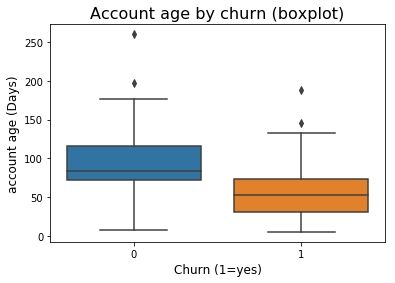

In [103]:
plt.figure(figsize = (6, 4))
sb.boxplot(data=df_model_pd, y='account_age', x='Churn_user')
plt.title('Account age by churn (boxplot)', fontsize=16)
plt.xlabel('Churn (1=yes)', fontsize=12)
plt.ylabel('account age (Days)', fontsize=12);

In [ ]:
#import pandas as pd
#pd.read_csv('sparkify.csv')

#### who Churn listens on less days and less songs per day
holds on average and looking at the distribution; the distribution for engangement is more clearly unimodal than for songs listened per day

In [ ]:
df_model.groupby('Churn_user').agg(avg(col('days_listened'))).orderBy('Churn_user').show()

In [ ]:
df_model_pd = df_model.groupby('Churn_user').agg(avg(col('days_listened'))).orderBy('Churn_user').toPandas()
sb.barplot(x='Churn_user', y='avg(days_listened)', data=df_model_pd)
plt.title('Days Listened by Churn')
plt.xlabel('Churn (1=yes)')
plt.ylabel('Days Listened');

In [ ]:
#fig = plt.figure(figsize = (7, 4))
#ax = fig.add_subplot(111)
#(df.retweet_count[df.p1_dog == True]).plot(kind = 'hist', bins = 20, alpha = .4, label = 'Dog identified', xlim = (0,15000))
#df.retweet_count[df.p1_dog == False].plot(kind = 'hist', alpha = .4, label = 'Dog not identified')

#plt.title('Retweets by Algorithm (ML) Identification', fontsize = 20)
#ax.set_xlabel('Retweets', fontsize = 16)
#ax.set_ylabel('Number of Tweets', fontsize = 16)
#ax.legend();


In [ ]:
df_model_pd = df_model.groupby('Churn_user').agg(avg(col('songs_per_day'))).orderBy('Churn_user').toPandas()
sb.barplot(x='Churn_user', y='avg(songs_per_day)', data=df_model_pd)
plt.title('Songs Listened per Day by Churn')
plt.xlabel('Churn (1=yes)')
plt.ylabel('Songs per Day');

In [ ]:
# plot distribution of songs per user & day listened
df_pd_0 = df_model.filter(df_model.Churn_user == 0).select('songs_per_day').toPandas()
df_pd_1 = df_model.filter(df_model.Churn_user == 1).select('songs_per_day').toPandas()

sb.distplot(df_pd_0.songs_per_day, hist=False, label='no churn')
sb.distplot(df_pd_1.songs_per_day, hist=False, label='churn')
plt.legend()
plt.title('Songs listened per day (frequency)');

In [ ]:
df_pd_0 = df_model.filter(df_model.Churn_user == 0).select('days_listened').toPandas()
df_pd_1 = df_model.filter(df_model.Churn_user == 1).select('days_listened').toPandas()

sb.distplot(df_pd_0.days_listened, hist=False, label='no churn')
sb.distplot(df_pd_1.days_listened, hist=False, label='churn')
plt.legend()
plt.title('Engagement: number of days listening to songs (frequency)');

Not looking at higher frequencies than days.

In [ ]:
# delete:
# by hour:

## udf = user-defined function
#get_hour = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).hour) 
#
## create column
#df = df.withColumn('hour', get_hour(user_log.ts)) # add 'hour' to dataframe
## df.head() 
#
## count next song page request by hour
#songs_in_hour = df.filter(df.page == 'NextSong').groupby(df.hour).count().orderBy(df.hour.cast('float'))
#songs_in_hour.show()
#
## visualize: transform to pandas
#songs_in_hour_pd = songs_in_hour.toPandas()
#plt.scatter(songs_in_hour_pd['hour'], songs_in_hour_pd['count'])
#plt.xlim(-1, 24);

In [ ]:
### create flag downgrade
#flag_downgrade_event = udf(lambda x: 1 if x=='Submit Downgrade' else 0, IntegerType())
#
### create downgraded column
#user_log_valid = user_log_valid.withColumn('downgraded', flag_downgrade_event('page'))
#user_log_valid.head()
#
### create flag free or paid phase
#windowval = Window.partitionBy('userId').orderBy(desc('ts')).rangeBetween(Window.unboundedPreceding, 0) # thinkof partition as groupBy; look at all preceeding rows but no following rows
#user_log_valid = user_log_valid.withColumn('phase', F.sum('downgraded').over(windowval))
#user_log_valid.select(['userId', 'firstName', 'ts', 'page', 'level', 'phase']).where(user_log.userId == '1138').sort('ts').collect()

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

Deciding on the best approach: choose approach 2
1. two-step optimization: a) obtain performance metrics for different estimators, choose the best, b) search the optimal parameter for the model from (a) with a grid or randomized search crossvalidation
2. one-step optimization: try different estimators based on parameter optimization for all of the models

$\rightarrow Approach (1) might not identify the best model as a higher performance boost from (1b) might yield the best model is one which was weaker at first.

In [ ]:
# rename target column
# using standards 'label' and 'features' as describedin docs: https://spark.apache.org/docs/latest/ml-classification-regression.html#random-forests
df_model = df_model.withColumnRenamed('Churn_user', 'label')

# train-test split
train, non_train = df_model.randomSplit([.6, .4], seed=42)
test, validate = non_train.randomSplit([.5, .5], seed=42)
print('Precise split of all rows:', df_model.count() == train.count() + test.count() + validate.count())

# number of records
print('rows -- total: {}, train: {}, test: {}, and validation: {}'.format(
    df_model.count(), train.count(), test.count(), validate.count()))

## baseline approach: multiple estimators, a single parameter choice

In [ ]:
# df_model.show(1)
# train.show(3)

In [ ]:
# build pipeline: use pipeline to prevent leaking knowledge from validation/test set
indexer = StringIndexer(inputCol='gender', outputCol='d_female')
assembler = VectorAssembler(inputCols=['days_listened', 'songs_per_day', 'account_age', 'd_female'], outputCol='features_unscaled')
scaler = StandardScaler(inputCol='features_unscaled', outputCol='features', withMean=True)

lr = LogisticRegression(maxIter=10, regParam=0.0, elasticNetParam=0)
rf = RandomForestClassifier(seed=42)
estimator_list = [lr, rf]

counter = 1
for estimator in estimator_list: # loop and how to obtain the algorithm name inspired by https://github.com/stephanieirvine/Udacity-Data-Scientist-Nanodegree/blob/main/Project%204/Sparkify.ipynb
    print('{}/{}: {}'.format(counter, len(estimator_list), estimator.__class__.__name__))
    counter += 1
    pipeline = Pipeline(stages=[indexer, assembler, scaler, estimator])
    start = time.time()
    model = pipeline.fit(train)
    result = model.transform(test)
    evaluator = MulticlassClassificationEvaluator()
    print('... ran {}min and yields:'.format(round((time.time() - start) / 60, 1)))
    print('f1: {}, and accuracy: {}'.format(
        round(evaluator.evaluate(result, {evaluator.metricName: 'f1'}), 2),
        round(evaluator.evaluate(result, {evaluator.metricName: 'accuracy'}), 2)))

## enhanced approach: multiple estimators, gridsearch over parameters

In [ ]:
paramGrid_LogisticRegression = ParamGridBuilder() \
    .addGrid(lr.regParam, [0.0, 0.1]) \
    .build()

# parameter options inspired by https://towardsdatascience.com/100x-faster-randomized-hyperparameter-searching-framework-with-pyspark-4de19e44f5e6
paramGrid_RandomForestClassifier = ParamGridBuilder() \
    .addGrid(rf.numTrees, [50, 100]) \
    .addGrid(rf.maxDepth, [2,10]) \
    .build()
    # rf.criterion,['gini','entropy']
        
def create_cv(paramGrid, pipeline):
    return CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=MulticlassClassificationEvaluator(metricName='f1'),
                          numFolds=3) # parallelism=2
# f1 metric only available using the Spark MulticlassClassificationEvaluator, so with the binary version https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.evaluation.BinaryClassificationEvaluator.html?highlight=binaryclassificationevaluator#pyspark.ml.evaluation.BinaryClassificationEvaluator

def evaluate_model(evaluator, result):
    ''' Evaluates the cross validation results.
    
    Input:
    evaluator -- instantiated evaluator object, e.g. MulticlassClassificationEvaluator()
    result -- cross-validation fit-transformed data
    
    Output:
    prints performance metrics f1, accuracy, and precision
    '''
    
    print('f1: {}'.format(round(evaluator.evaluate(result, {evaluator.metricName: 'f1'}), 2)))
    # accuracy and precision
    correct_prediction_count, rows_all = result.filter(result.label == result.prediction).count(), result.count()
    precision_count, rows_precision = result.filter((result.label == 1) & (result.prediction == 1)).count(), result.filter(result.label == 1).count()
    print('accuracy: {:.0%} ({}/{}), and precision: {:.0%} ({}/{})'.format(
        correct_prediction_count / rows_all, correct_prediction_count, rows_all,
        precision_count / rows_precision, precision_count, rows_precision))
    print('... ran {} min.'.format(round((time.time() - start) / 60, 1)))

# https://towardsdatascience.com/100x-faster-randomized-hyperparameter-searching-framework-with-pyspark-4de19e44f5e6
#num_trees =  random.choice(list(range(50,500)))
#depth = random.choice(list(range(2,10)))
#criterion = random.choice(['gini','entropy'])
# relevant read?: https://towardsdatascience.com/hyperparameters-part-ii-random-search-on-spark-77667e68b606

In [ ]:
# reduced search...
#paramGrid_LogisticRegression = ParamGridBuilder() \
#    .addGrid(lr.regParam, [0.0]) \
#    .build()

# parameter options inspired by https://towardsdatascience.com/100x-faster-randomized-hyperparameter-searching-framework-with-pyspark-4de19e44f5e6
#paramGrid_RandomForestClassifier = ParamGridBuilder() \
#    .addGrid(rf.numTrees, [2]) \
#    .build()
#    # rf.criterion,['gini','entropy']

In [ ]:
#for estimator in estimator_list:
#    print(eval('paramGrid_' + estimator.__class__.__name__))

In [ ]:
# combine with gridsearch
counter = 1
best_f1 = 0

for estimator in estimator_list: # see credentials above
    print('{}/{}: {}'.format(counter, len(estimator_list), estimator.__class__.__name__))
    counter += 1
    pipeline = Pipeline(stages=[indexer, assembler, scaler, estimator])
    
    # create the CrossValidator object with the specific parameter grid and pipeline: 
    cv = create_cv(eval('paramGrid_' + estimator.__class__.__name__), pipeline)
    
    start = time.time()
    model = cv.fit(train)
    result = model.transform(test)
    evaluator = MulticlassClassificationEvaluator()
    f1 = round(evaluator.evaluate(result, {evaluator.metricName: 'f1'}), 2)
    if f1 > best_f1:
        best_f1 = round(evaluator.evaluate(result, {evaluator.metricName: 'f1'}), 2)
        model_best = model.bestModel
    evaluate_model(evaluator, result)

In [ ]:
print(best_f1)
model_best

In [ ]:
# save model to files: can use it without running the training job first
# https://stackoverflow.com/questions/29255145/what-is-the-right-way-to-save-load-models-in-spark-pyspark?noredirect=1&lq=1
model_best.write().overwrite().save('pyspark_trained_model')

In [ ]:
# https://stackoverflow.com/questions/52625639/unable-to-load-logistic-regression-model-in-spark-2-x
model_trained = PipelineModel.load('pyspark_trained_model')

# inspired by https://spark.apache.org/docs/latest/ml-pipeline.html#ml-persistence-saving-and-loading-pipelines
prediction = model_trained.transform(validate.select(validate.drop('label').columns))
selected = prediction.select(prediction.drop('features_unscaled', 'features', 'rawPrediction').columns)
#selected.collect()
#for row in selected.collect():
#    userId, gender, days_listened, songs_per_day, d_female, prob, prediction = row  # type: ignore
#    print(userId, prob[1], prediction)

Baseline accuracy: always predict the majority class no churn: 

In [ ]:
round(prediction.filter(col('label') == 0).count() / prediction.count(), 2)

Bad results with the small dataset do not mean no hope. More data is expected to be more helpful for better results than improvements in terms of parameter choice.

In [ ]:
# validate results
prediction = model_trained.transform(validate)
evaluate_model(evaluator, result=prediction)


In [ ]:
df_model.show(1)

### Predicting on new data
In a real-world application we should leave out the newest data, train a model and test it with the newest data. This can be extended rolling backwards. In this analysis we include all history. We pick up a signal which already led to churn. However, when churn will happen in reality but is not observed yet that training observation is labeled as 'no churn'. This weakens the model. We accept this flaw as out of scope for this project in terms of effort yet easily handled with the concepts presented.

Here we apply the best model found to the full dataset. This allows to provide a churn probability for all customers in the Sparkify Callcenter Dashboard web app.

In [ ]:
prediction_all = model_trained.transform(df_model)
prediction_all = prediction_all.select(prediction.drop('features_unscaled', 'features', 'rawPrediction').columns)
evaluate_model(evaluator, result=prediction_all)

In [ ]:
sparkify = prediction_all.toPandas()
sparkify['probability'] = sparkify.probability.apply(lambda x: x[1])
sparkify['userId'] = sparkify.userId.apply(int)
#sparkify.to_csv('sparkify.csv', index=False)

from sqlalchemy import create_engine

engine = create_engine('sqlite:///sparkify.db')
sparkify.to_sql('user_table', engine, index=False, if_exists='replace')

print('Check database content... table exists and has entries:', 
      pd.read_sql('SELECT * FROM user_table', 
                  con=engine).shape[0] > 0)

In [ ]:
sparkify.head(3)

In [ ]:
# given low amount of features: hardly able to predict churn
print(np.corrcoef(sparkify.label, sparkify.probability)[0,1])
plt.scatter(x=sparkify.label, y=sparkify.probability);

In [ ]:
#for row in selected.collect():
#    userId, gender, days_listened, songs_per_day, d_female, prob, prediction = row  # type: ignore
#    print(userId, prob[1], prediction)

In [ ]:
#print(rf.explainParams())
#cvModel.avgMetrics

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.

In [ ]:
# compare against:
# https://github.com/stephanieirvine/Udacity-Data-Scientist-Nanodegree/blob/main/Project%204/Sparkify.ipynb
# blog: https://medium.com/swlh/predicting-churn-with-pyspark-4c8edc8a19e0

# https://towardsdatascience.com/predicting-customer-churn-using-pyspark-6a78a78a8412